# Analyse unanswered written questions in the House of Commons

We wanted to analyse how many written questions asked in the House of Commons from December 2020 to July 2022 could not be answered because the department did not have the requisite data.

We first obtained text for all the written answers for the relevant period from TheyWorkForYou. In this notebook:

- we perform some high-level analysis on this data to get a sense of how many questions are asked, who asks them, and how many of them are quantitative
- we identify common strings that may indicate questions that could not be answered due to lack of data
- we write these questions to separate files for manual review. 

We then reviewed these questions manually, to see which of these questions were truly unanswered, and what themes recurred for each Department.

NB: The text of Hansard answers remains under [Parliamentary copyright](https://www.parliament.uk/site-information/copyright-parliament/).

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load data

We have previously scraped all written questions answered, from TheyWorkForYou. Load these into a dataframe.

In [82]:
dfs = [pd.read_csv("./data/output_2022-01-10.csv"), pd.read_csv("./data/output_2022.csv")]
df = pd.concat(dfs)

In [83]:
df.replace(np.nan, '', regex=True, inplace=True)
df.date_submitted = pd.to_datetime(df.date_submitted)#, format="%d/%m/%Y")
df.date_answered = pd.to_datetime(df.date_answered)#, format="%d/%m/%Y")
pd.options.display.max_colwidth = 50
print(len(df), "questions in our dataset")

83968 questions in our dataset


## Examine question frequency over time

Note that a small number of questions were submitted prior to the period, but only answered later - this doesn't matter for the purpose of our analysis.

These largely seem to follow the [patterns of Parliamentary recess](https://www.parliament.uk/about/faqs/house-of-commons-faqs/business-faq-page/recess-dates/).

Note also that this dataset only contains answered questions, there may be others that haven't been answered yet.

<AxesSubplot:title={'center':'Count of questions submitted by month'}, xlabel='date_submitted,date_submitted'>

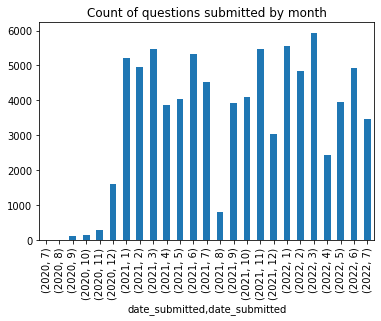

In [84]:
df.groupby([df.date_submitted.dt.year, df.date_submitted.dt.month]).url.size()\
    .plot(kind="bar", title="Count of questions submitted by month")

<AxesSubplot:title={'center':'Count of questions answered by month'}, xlabel='date_answered,date_answered'>

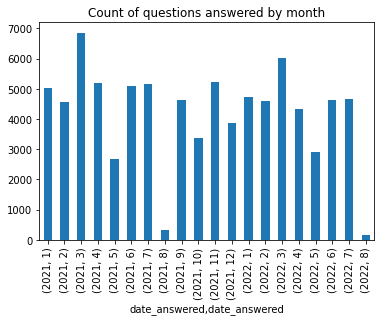

In [85]:
df.groupby([df.date_answered.dt.year, df.date_answered.dt.month]).url.size()\
    .plot(kind="bar", title="Count of questions answered by month")

## Which departments get asked most questions overall?

DHSC - presumably Covid. FCDO - presumably due to Ukraine.

In [88]:
df.department.value_counts().head(10)

Department of Health and Social Care                       16932
Foreign, Commonwealth and Development Office                9034
Department for Business, Energy and Industrial Strategy     6645
Home Office                                                 6533
Department for Transport                                    5641
Department for Education                                    5193
Treasury                                                    4960
Department for Environment, Food and Rural Affairs          4391
Department for Work and Pensions                            4337
Ministry of Defence                                         4030
Name: department, dtype: int64

In [87]:
df.department.value_counts(normalize=True).head(10) * 100

Department of Health and Social Care                       20.164825
Foreign, Commonwealth and Development Office               10.758861
Department for Business, Energy and Industrial Strategy     7.913729
Home Office                                                 7.780345
Department for Transport                                    6.718035
Department for Education                                    6.184499
Treasury                                                    5.907012
Department for Environment, Food and Rural Affairs          5.229373
Department for Work and Pensions                            5.165063
Ministry of Defence                                         4.799447
Name: department, dtype: float64

DHSC got answered most questions even before the Covid crisis. 

In [92]:
# df.groupby([df.date_answered.dt.year, df.date_answered.dt.month, df.department]).size()

In [93]:
# df[df.date_submitted.dt.month < 3].department.value_counts().head(10)

In [94]:
def get_major_department(dept):
    if dept != 'Department of Health and Social Care' \
        and dept != 'Home Office' \
        and dept != 'Treasury'\
        and dept != 'Department for Transport' \
        and dept != 'Department for Education'\
        and dept != 'Foreign and Commonwealth Office' \
        and dept != 'Department for Business, Energy and Industrial Strategy' \
        and dept != 'Ministry of Housing, Communities and Local Government':
        return 'aaOther'
    return dept

df['department_major'] = df.department.apply(get_major_department)

Chart questions to each major department, by month. Note that DHSC received the most questions even before Covid.

<AxesSubplot:xlabel='date_submitted,date_submitted'>

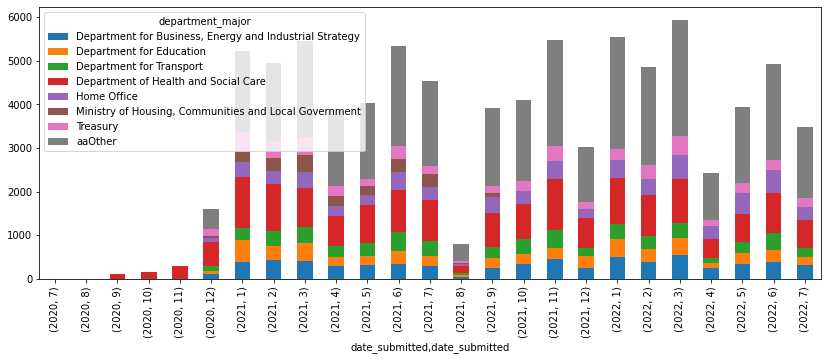

In [105]:
df.groupby([df.date_submitted.dt.year, df.date_submitted.dt.month, df.department_major]).url.count()\
    .unstack(level=-1) \
    .plot(kind="bar", stacked=True, figsize=(14,5))

In [56]:
# Look at June, the busiest month, in more detail
# df[(df.date_submitted.dt.month == 6) & (df.date_submitted.dt.year == 2020)].department.value_counts().head(10)

Series([], Name: department, dtype: int64)

## Who asks the most questions?

Shadow ministers tend to ask lots, unsurprisingly. Some opposition backbenchers can be very active too. (Thus, it's worth remembering that the question set isn't necessarily representative of the overall concerns of MPs.)

NB: Lords [can ask questions in the Commons](https://www.theyworkforyou.com/wrans/?id=2019-12-19.HL95.h) too.

In [106]:
len(df.question_speaker.value_counts())

965

In [107]:
df.question_speaker.value_counts().head(10)

Rachael Maskell    3067
Jim Shannon        1167
Tan Dhesi          1149
Kevan Jones        1015
Ruth Jones         1005
Chi Onwurah         943
Caroline Lucas      858
Justin Madders      854
Daisy Cooper        842
Lyn Brown           833
Name: question_speaker, dtype: int64

In [108]:
df.groupby(['question_speaker', 'question_position']).url.count().sort_values(ascending=False).head(20)

question_speaker         question_position                                                                                                  
Rachael Maskell          Shadow Minister (Digital, Culture, Media and Sport)                                                                    3067
Jim Shannon              Shadow DUP Spokesperson (Human Rights), Shadow DUP Spokesperson (Health)                                               1167
Tan Dhesi                Shadow Minister (Transport)                                                                                            1149
Kevan Jones              Labour, North Durham                                                                                                   1015
Ruth Jones               Shadow Minister (Environment, Food and Rural Affairs)                                                                  1005
Chi Onwurah              Shadow Minister (Business, Energy and Industrial Strategy), Shadow Minister (Digital, Cul

In [109]:
df.question_position.value_counts().head(20)

Shadow Minister (Digital, Culture, Media and Sport)                                                                3452
Conservative                                                                                                       2056
Crossbench                                                                                                         1931
Labour                                                                                                             1925
Shadow Minister (Transport)                                                                                        1681
Non-affiliated                                                                                                     1645
Shadow Minister (Environment, Food and Rural Affairs)                                                              1420
Liberal Democrat                                                                                                   1375
Shadow Minister (Health and Social Care)

## Identify quantitative questions

Written questions can seek quantitative or non-quantitative information. Common phrases for quantitative questions include "how many", "how much", "what estimate", etc.

About one-sixth of questions contain these phrases, so are probably or definitely quantitative in nature. This is not definitive, because some quantitative questions also contain other phrases. Also, the phrase 'what assessment' is used sometimes in quantitative questions, although it's frequently used in non-quantitative questions too, so isn't useful for filtering.

In [110]:
s_quantitative = 'how many|how much|what estimate|what proportion|what the average'
df['is_quantitative'] = df.question_text.str.contains(s_quantitative, case=False, regex=True)
df_quantitative = df[df.is_quantitative]
print(len(df_quantitative), 'quantitative questions submitted')
print("%.1f%% of the total" % (len(df_quantitative) / len(df) * 100))

14488 quantitative questions submitted
17.3% of the total


DHSC, HO, DWP, MoD, BEIS receive more quantitative questions than other departments, relatively speaking.

In [111]:
df_quantitative.department.value_counts().head(10)

Department of Health and Social Care                       2663
Home Office                                                1687
Department for Work and Pensions                           1164
Ministry of Defence                                        1127
Department for Business, Energy and Industrial Strategy     969
Department for Education                                    967
Ministry of Justice                                         952
Treasury                                                    835
Department for Transport                                    818
Foreign, Commonwealth and Development Office                762
Name: department, dtype: int64

In [112]:
df_quantitative.department.value_counts(normalize=True).head(10)

Department of Health and Social Care                       0.183807
Home Office                                                0.116441
Department for Work and Pensions                           0.080342
Ministry of Defence                                        0.077789
Department for Business, Energy and Industrial Strategy    0.066883
Department for Education                                   0.066745
Ministry of Justice                                        0.065710
Treasury                                                   0.057634
Department for Transport                                   0.056461
Foreign, Commonwealth and Development Office               0.052595
Name: department, dtype: float64

In [154]:
temp = df.groupby(df.department).agg(total_quant=('is_quantitative', 'sum'), total_questions=('is_quantitative', 'size'))
temp['proportion_quant'] = temp.total_quant / temp.total_questions * 100
temp.sort_values("proportion_quant", ascending=False)

,total_quant,total_questions,proportion_quant
department,,,
Members Estimate Committee,2,3,66.666667
Ministry of Justice,952,2849,33.415233
Attorney General,91,273,33.333333
Ministry of Defence,1127,4030,27.965261
Department for Work and Pensions,1164,4337,26.838829
Home Office,1687,6533,25.822746
Speaker's Committee for the Independent Parliamentary Standards Authority,2,8,25.000000
The Senior Deputy Speaker,19,87,21.839080
Cabinet Office,431,2026,21.273445


## Extract questions that could not be answered

Common text patterns for saying 'we do not have the data' in the answer include "is not held" (and variants), "is not collected", "is not available", "disproportionate cost" and "no central". 

There are 2265 such questions in the dataset, or about 5% of the total. However, such questions need manual review, because in some cases the department says it doesn't hold the data itself but refers the questioner to a different authority that does; does not have (e.g.) data by constituency but provides data by local authority; or uses the phrase in another context entirely. 

In [157]:
s_notheld = 'do(es)? not (currently|routinely)?\s?(hold|collect|record|publish)'
s_notheld += '|(is|are) not (currently|routinely)?\s?(available|recorded|held|collected|published)'
s_notheld += '|(is|are) (currently)?\s?unavailable'
s_notheld += '|unable to answer|disproportionate cost|no(t)? central(ly)?'
df['contains_not_held_string'] = df.answer_text.str.contains(s_notheld, case=False, regex=True)

# test_str = pd.Series(['The Home Office does not hold information.'])
# test_str.str.contains(s_notheld, case=False, regex=True)
df_not_held = df[df.contains_not_held_string]
print(len(df_not_held), "questions contain 'not held' string")

df['contains_not_held_string_and_isquant'] = df.is_quantitative & df.contains_not_held_string
print(len(df[df.contains_not_held_string_and_isquant]), 'of these appear quantitative')

# NB Some departments seem to use the following 'not possible' strings a lot - some not at all.
s_notpossible = 'not possible to answer|not be possible to answer'
df['contains_not_possible_string'] = df.answer_text.str.contains(s_notpossible, case=False, regex=True)
df_not_possible = df[df.contains_not_possible_string]
print(len(df_not_possible), 'were flagged as "not possible" to answer')

/var/folders/h5/r_p1fbvx13g1hf0c15pjx60h0000gn/T/ipykernel_95747/1028169669.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['contains_not_held_string'] = df.answer_text.str.contains(s_notheld, case=False, regex=True)


5508 questions contain 'not held' string
3654 of these appear quantitative
739 were flagged as "not possible" to answer


Save the flagged output to local CSV for manual analysis.

In [117]:
df.to_csv('./data/output_with_flags_2021_22.csv', index=False)

As a rough indicator, which departments' answers most commonly contain phrases indicating that the information is not held? (But note that this doesn't necessarily mean they actually were unanswered, for the reasons given above.)

In [118]:
df_not_held.department.value_counts().head(10)

Department of Health and Social Care                       1858
Home Office                                                 709
Department for Work and Pensions                            508
Department for Education                                    416
Ministry of Justice                                         382
Treasury                                                    261
Department for Transport                                    200
Department for Business, Energy and Industrial Strategy     180
Ministry of Defence                                         172
Cabinet Office                                              154
Name: department, dtype: int64

In [119]:
df_not_held.department.value_counts(normalize=True).head(10)

Department of Health and Social Care                       0.337328
Home Office                                                0.128722
Department for Work and Pensions                           0.092229
Department for Education                                   0.075527
Ministry of Justice                                        0.069354
Treasury                                                   0.047386
Department for Transport                                   0.036311
Department for Business, Energy and Industrial Strategy    0.032680
Ministry of Defence                                        0.031227
Cabinet Office                                             0.027959
Name: department, dtype: float64

In [156]:
temp = df.groupby(df.department).agg(
    total_not_held=('contains_not_held_string', 'sum'),
    total_not_possible=('contains_not_possible_string', 'sum'),
    total_quant=('is_quantitative', 'sum'),
    total_questions=('is_quantitative', 'size'))
temp['proportion_quant_notheld'] = temp.total_not_held / temp.total_quant * 100
temp['proportion_quant_notpossible'] = temp.total_not_possible / temp.total_quant * 100
temp.sort_values("proportion_quant_notheld", ascending=False)

,total_not_held,total_not_possible,total_quant,total_questions,proportion_quant_notheld,proportion_quant_notpossible
department,,,,,,
Women and Equalities,5,0,7,313,71.428571,0.000000
Department of Health and Social Care,1858,532,2663,16932,69.770935,19.977469
Church Commissioners,8,2,15,87,53.333333,13.333333
Attorney General,41,0,91,273,45.054945,0.000000
Department for Work and Pensions,508,27,1164,4337,43.642612,2.319588
Department for Education,416,1,967,5193,43.019648,0.103413
Home Office,709,108,1687,6533,42.027267,6.401897
Ministry of Justice,382,0,952,2849,40.126050,0.000000
"Ministry of Housing, Communities and Local Government",129,8,331,2167,38.972810,2.416918


Examine the count of possibly unanswered questions by month - this looks a lot like the overall pattern above.

<AxesSubplot:title={'center':'Count of (possibly) unanswered questions by month'}, xlabel='date_submitted,date_submitted'>

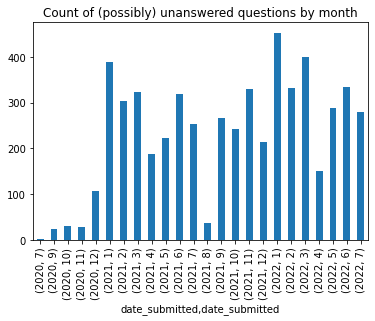

In [121]:
df_not_held.groupby([df_not_held.date_submitted.dt.year, df_not_held.date_submitted.dt.month])\
    .url.count().plot(kind="bar", title="Count of (possibly) unanswered questions by month")

Now we can manually review these questions and pick out the themes.

### Counts by department

Obviously these need to be approached with caution, but are useful for indicative purposes.

The big departments with relatively 'not held' counts are the DHSC, DWP, MoJ, and Home Office.

The big departments with relatively low 'not held' counts include DfT and the Treasury.

In [158]:
department_totals = df.groupby("department").sum()[['contains_not_held_string', 'is_quantitative']]
department_counts = df.groupby("department").count().url
department = department_totals.join(department_counts).sort_values('url', ascending=False)
department["total_questions"] = department.url
department["percent_quantitative"] = department.is_quantitative / department.total_questions * 100
department["percent_notheld"] = department.contains_not_held_string / department.is_quantitative * 100
cols = ["total_questions", "is_quantitative", "percent_quantitative", "contains_not_held_string", "percent_notheld"]
department[cols].sort_values("percent_notheld", ascending=False)

,total_questions,is_quantitative,percent_quantitative,contains_not_held_string,percent_notheld
department,,,,,
Women and Equalities,313,7,2.236422,5,71.428571
Department of Health and Social Care,16932,2663,15.727616,1858,69.770935
Church Commissioners,87,15,17.241379,8,53.333333
Attorney General,273,91,33.333333,41,45.054945
Department for Work and Pensions,4337,1164,26.838829,508,43.642612
Department for Education,5193,967,18.621221,416,43.019648
Home Office,6533,1687,25.822746,709,42.027267
Ministry of Justice,2849,952,33.415233,382,40.126050
"Ministry of Housing, Communities and Local Government",2167,331,15.274573,129,38.972810


In [131]:
department.to_csv("by_department.csv")

### Save a department's questions, for analysis

In [163]:
# df.columns

In [166]:
df.question_text = df.question_text.str.strip()
cols_in_order = [
    'title', 'url',
    'question_text', 'answer_text',
    'is_quantitative', 'contains_not_held_string',
    'contains_not_held_string_and_isquant',
    'contains_not_possible_string',
    'date_submitted', 'date_answered',
    'question_speaker', 'question_position',
    'answer_speaker', 'answer_position',
]

In [167]:
df[df.department == "Ministry of Justice"][cols_in_order].to_csv('./data/moj_2021_22.csv', index=False)